## Import Libraries and data


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import scipy
# from charset_normalizer import md__mypyc
# Importing Deep Learning Libraries
# from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras import regularizers
from keras.utils import load_img,img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
from keras.optimizers import Adam,SGD,RMSprop

In [7]:
expression = 'disgust'

# plt.figure(figsize= (12,12))
# for i in range(1, 10, 1):
#     plt.subplot(3,3,i)
#     img = load_img("train/"+expression+"/"+
#                   os.listdir("train/" + expression)[i], target_size=(picture_size, picture_size))
#     plt.imshow(img)   
# plt.show()
emotion_labels = ['Angry','Disgust','Fear','Happy','Neutral', 'Sad', 'Surprise']
train_count=[]
test_count=[]
for i in emotion_labels:
    train_count.append(len(os.listdir("train/"+i)))
    test_count.append(len(os.listdir("test/"+i)))


In [8]:
for i in range(len(train_count)):
    print(emotion_labels[i],train_count[i]+test_count[i])

Angry 4953
Disgust 1094
Fear 5121
Happy 8989
Neutral 6198
Sad 6077
Surprise 4002


In [9]:
print(sum(train_count)+sum(test_count))

36434


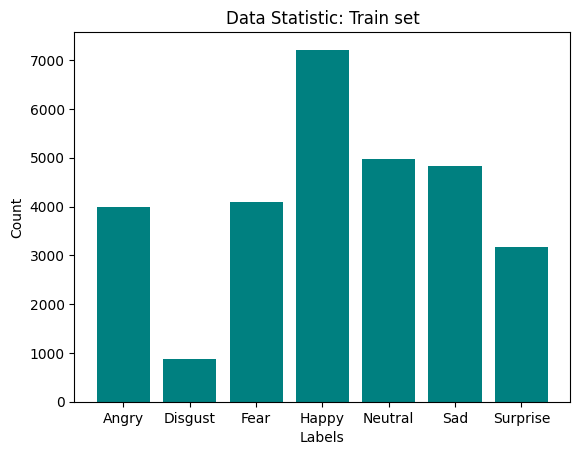

In [10]:
plt.bar(emotion_labels,train_count,color="#008080")
plt.title("Data Statistic: Train set")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.show()

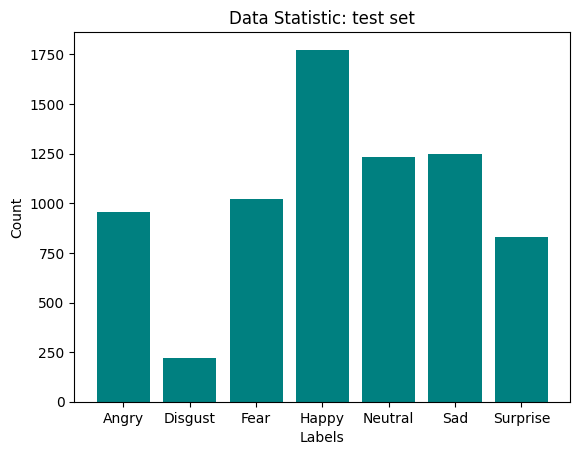

In [11]:
plt.bar(emotion_labels,test_count,color="#008080")
plt.title("Data Statistic: test set")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.show()

## Data Preprocessing

In [12]:
train_datagen = ImageDataGenerator(
    width_shift_range = 0.1,        # Randomly shift the width of images by up to 10%
    height_shift_range = 0.1,       # Randomly shift the height of images by up to 10%
    horizontal_flip = True,         # Flip images horizontally at random
    rescale = 1./255,               # Rescale pixel values to be between 0 and 1
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255,               # Rescale pixel values to be between 0 and 1
    validation_split = 0.2          # Set aside 20% of the data for validation
)

In [13]:
batch_size  = 64



train_set = train_datagen.flow_from_directory("train",
                                              target_size =  (48, 48),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True,
                                              subset="training")


test_set = validation_datagen.flow_from_directory("test",
                                              target_size =  (48, 48),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False,
                                              subset="validation")

Found 29145 images belonging to 7 classes.
Found 1454 images belonging to 7 classes.


## Network Structure


In [14]:
from keras.optimizers import Adam,SGD,RMSprop

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
    
model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten()) 
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
    
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model.compile(
    optimizer = Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       2

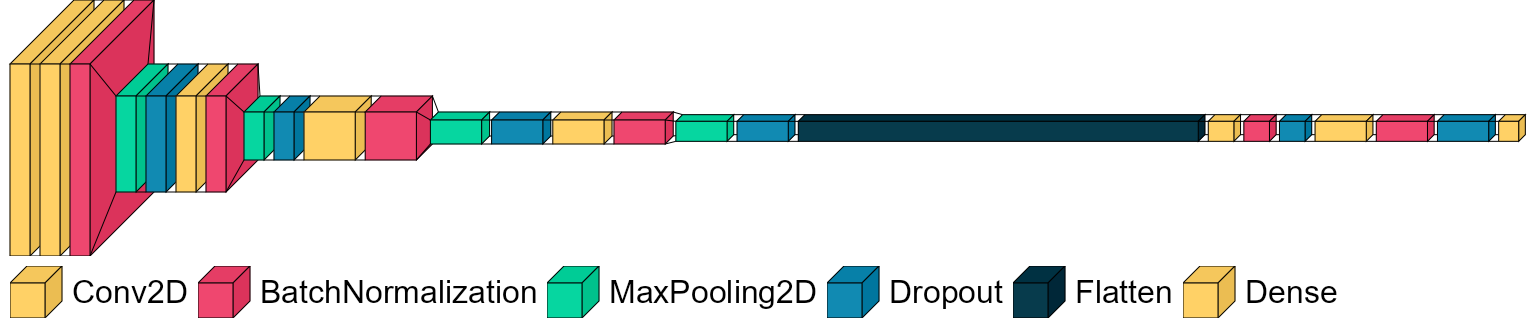

In [15]:
import visualkeras

from PIL import ImageFont

font = ImageFont.truetype("arial.ttf", 32)  # using comic sans is strictly prohibited!
visualkeras.layered_view(model, legend=True, font=font)  # font is optional!



In [16]:
layers=model.layers
filters, biases=model.layers[0].get_weights()
print(layers[0].name, filters.shape)


conv2d (3, 3, 1, 32)


In [17]:

conv_layer_index=[0,1,5,9,14]
outputs = [model.layers[i].output for i in conv_layer_index]
model_short = Model(inputs=model.inputs, outputs=outputs)

print(model_short.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0     

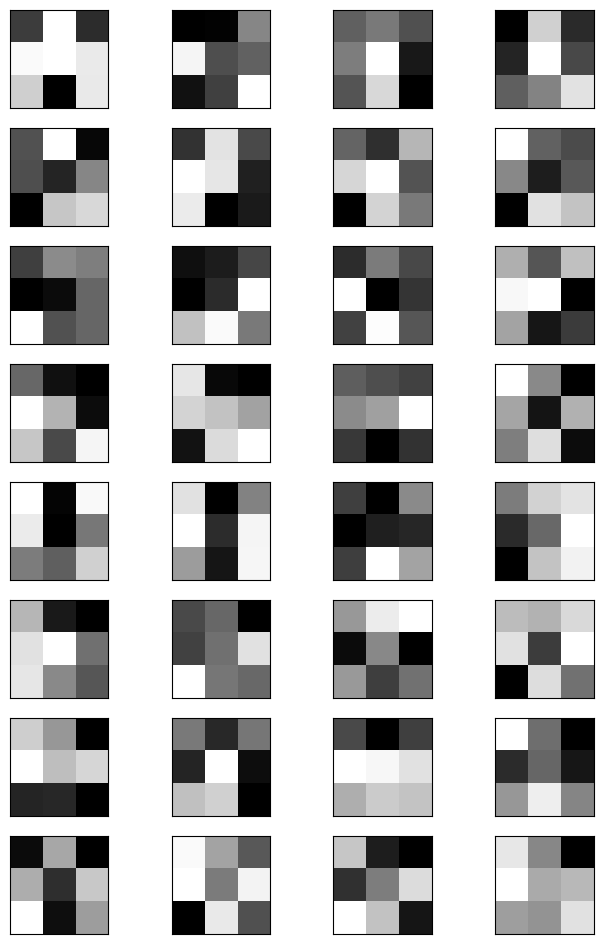

In [18]:
fig1=plt.figure(figsize=(8, 12))
columns = 4
rows = 8
n_filters = columns * rows
for i in range(1, n_filters +1):
    f = filters[:, :, :, i-1]
    fig1 =plt.subplot(rows, columns, i)
    fig1.set_xticks([])  #Turn off axis
    fig1.set_yticks([])
    plt.imshow(f[:, :, 0], cmap='gray') #Show only the filters from 0th channel (R)
    #ix += 1
plt.show()    


In [19]:
import cv2
img = load_img('MYFACE.jpg', target_size=(48, 48)) #VGG user 224 as input
img = img_to_array(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# convert the image to an array

img = np.expand_dims(img, axis=0)

In [20]:
feature_output = model_short.predict(img)

1/1 [==============================] - 0s 198ms/step


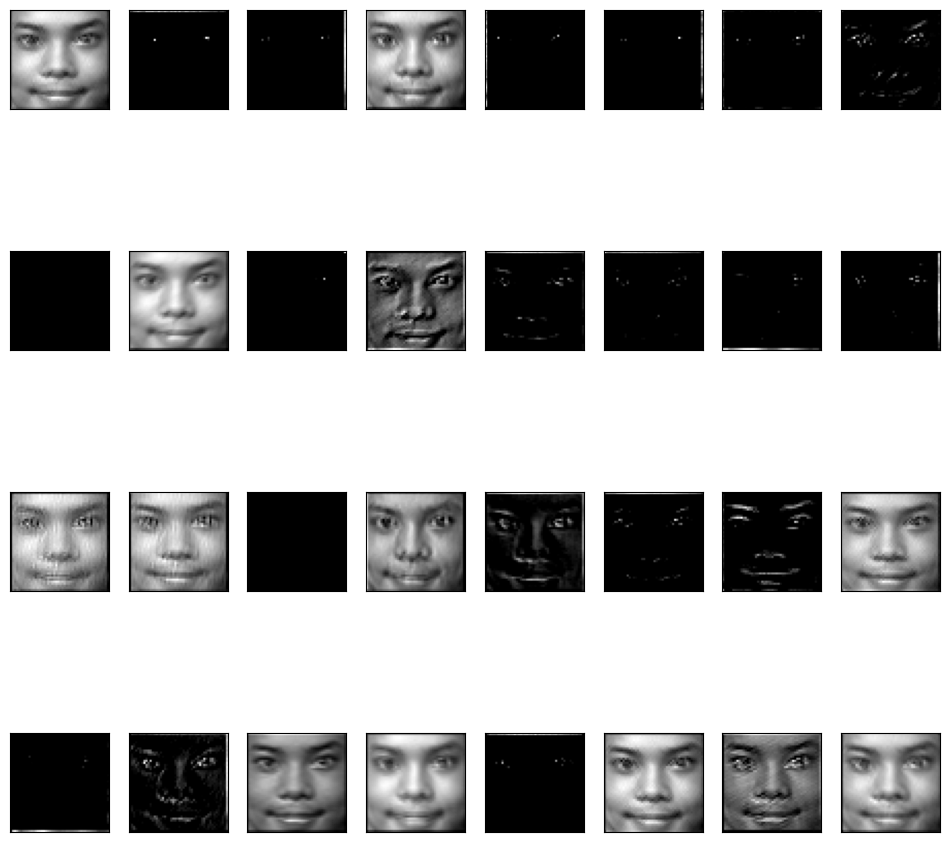

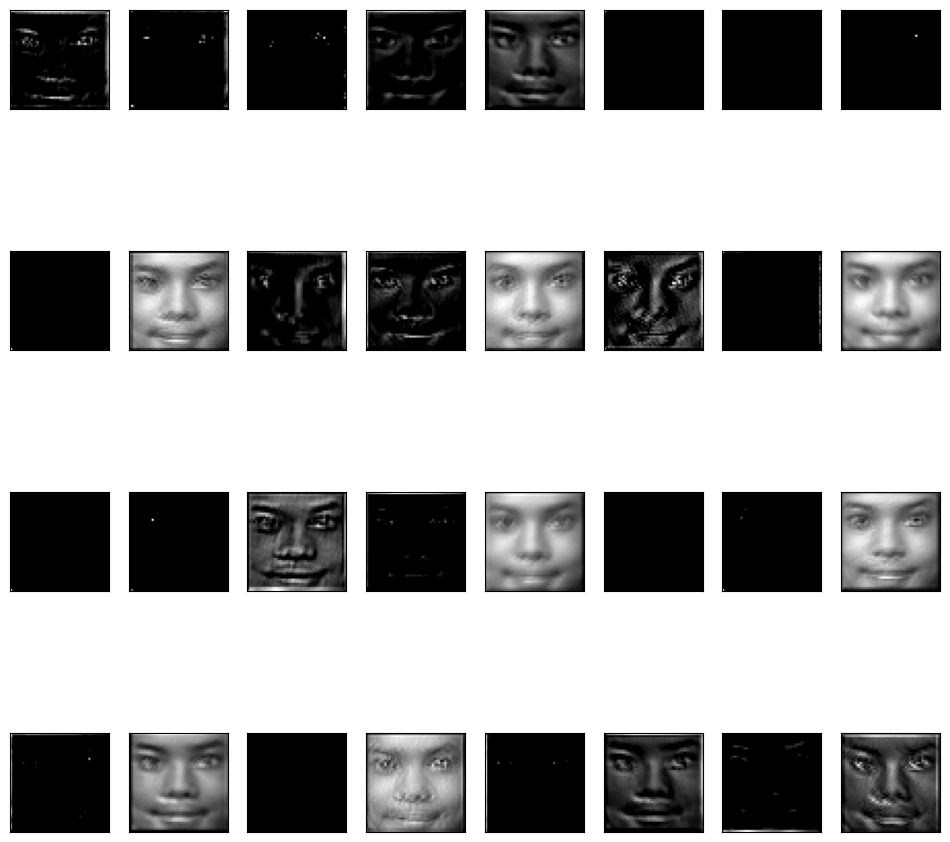

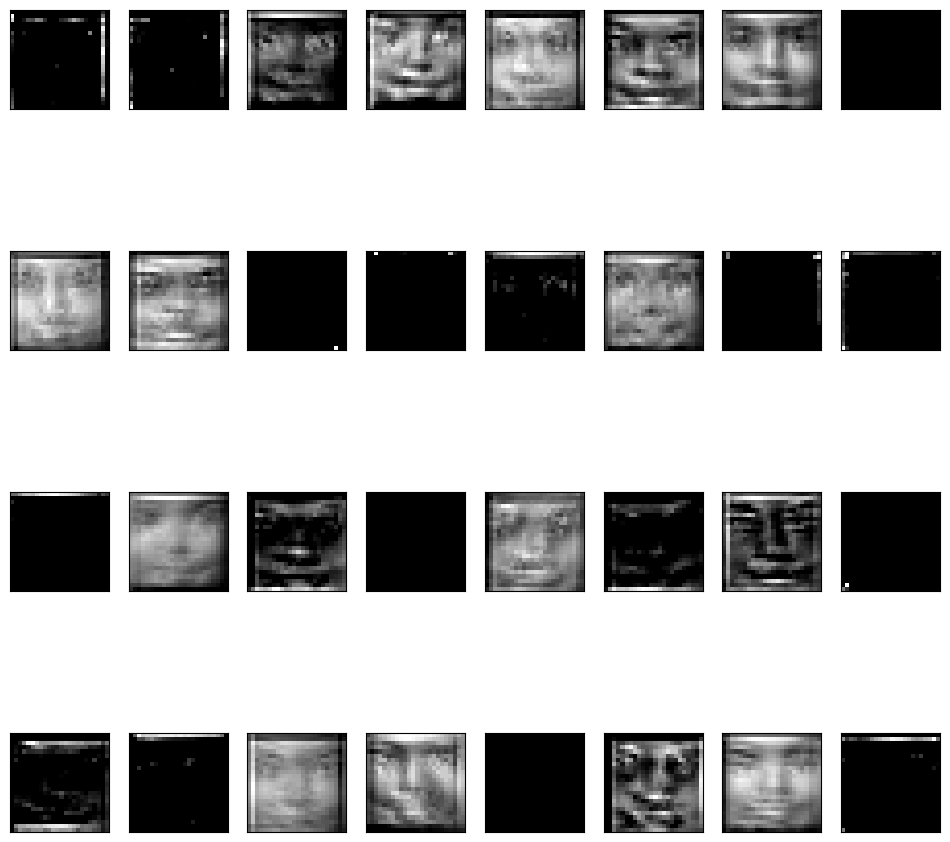

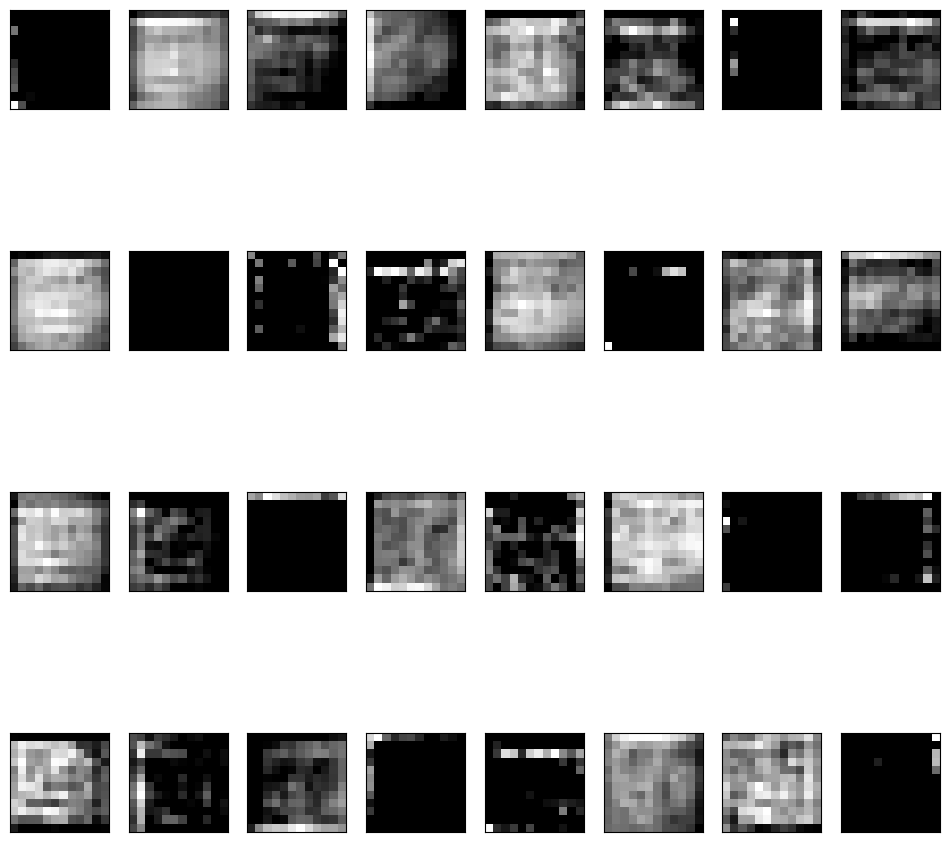

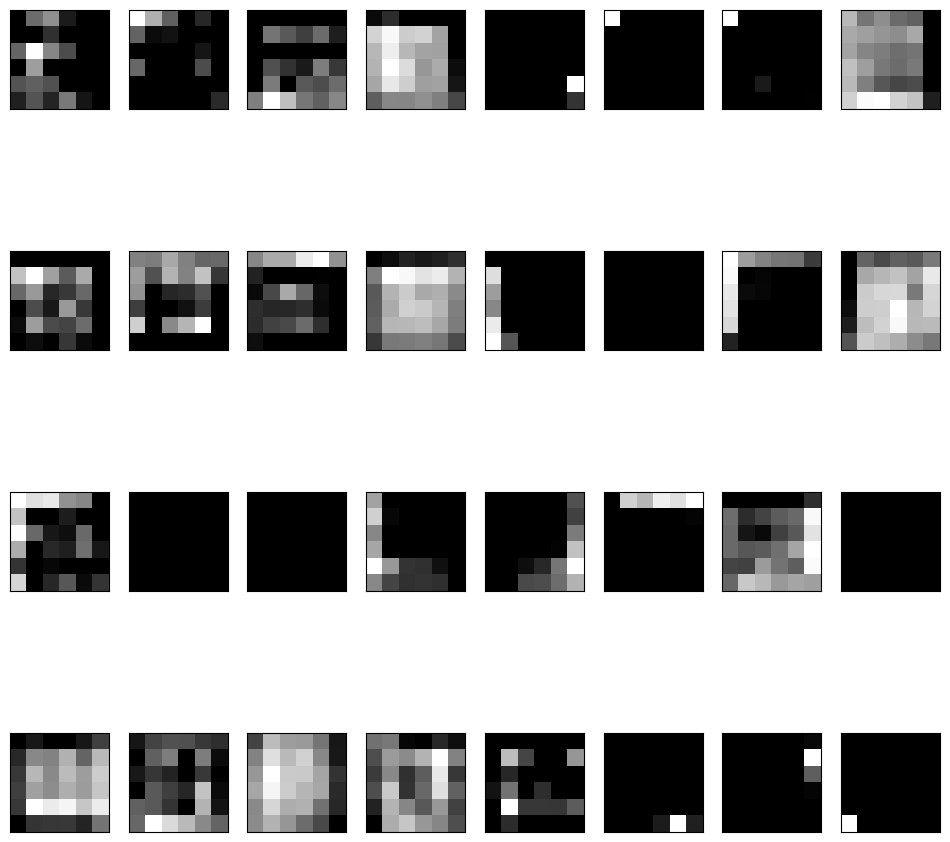

In [21]:
columns = 8
rows = 4
for ftr in feature_output:
    #pos = 1
    fig=plt.figure(figsize=(12, 12))
    for i in range(1, columns*rows +1):
        fig =plt.subplot(rows, columns, i)
        fig.set_xticks([])  #Turn off axis
        fig.set_yticks([])
        plt.imshow(ftr[0, :, :,i-1], cmap='gray')
        #pos += 1
    plt.show()

## Training Network

In [89]:
from keras.callbacks import ModelCheckpoint

# Define the callback
checkpoint_callback = ModelCheckpoint(
    filepath='model_weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)


In [90]:
# Train the model with the callback
history = model.fit(
    train_set,
    steps_per_epoch=len(train_set),
    epochs=100,
    validation_data=test_set,
    validation_steps=len(test_set),
    callbacks=[checkpoint_callback]
)

Epoch 1/100
456/456 [==============================] - ETA: 0s - loss: 9.1810 - accuracy: 0.1932
Epoch 1: val_accuracy improved from -inf to 0.16437, saving model to model_weights.h5
456/456 [==============================] - 284s 613ms/step - loss: 9.1810 - accuracy: 0.1932 - val_loss: 8.5747 - val_accuracy: 0.1644
Epoch 2/100
456/456 [==============================] - ETA: 0s - loss: 7.8850 - accuracy: 0.2328
Epoch 2: val_accuracy improved from 0.16437 to 0.28061, saving model to model_weights.h5
456/456 [==============================] - 240s 527ms/step - loss: 7.8850 - accuracy: 0.2328 - val_loss: 7.0524 - val_accuracy: 0.2806
Epoch 3/100
456/456 [==============================] - ETA: 0s - loss: 6.6235 - accuracy: 0.2645
Epoch 3: val_accuracy improved from 0.28061 to 0.32600, saving model to model_weights.h5
456/456 [==============================] - 35s 77ms/step - loss: 6.6235 - accuracy: 0.2645 - val_loss: 5.8970 - val_accuracy: 0.3260
Epoch 4/100
456/456 [=====================

## Result

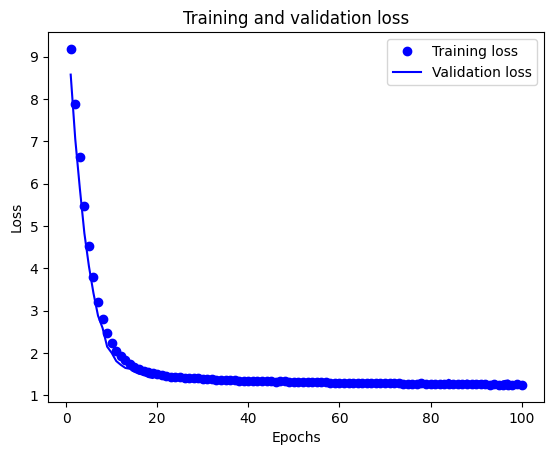

In [91]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

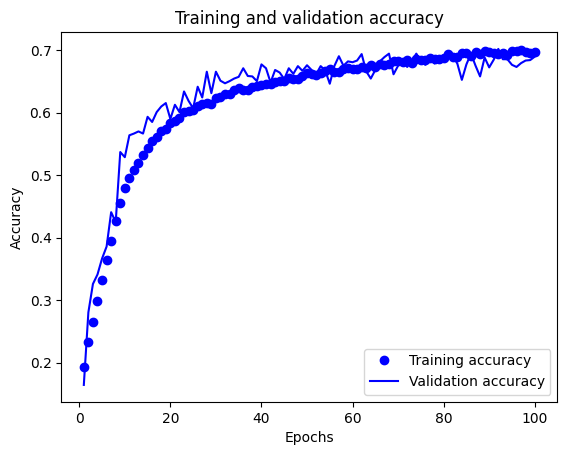

In [92]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


23/23 [==============================] - 2s 60ms/step


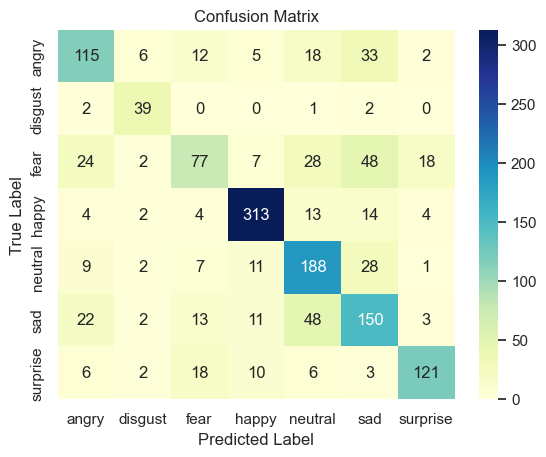

In [93]:
import seaborn as sns 
from sklearn import metrics

# Get the true labels and predicted labels for the validation set
validation_labels = test_set.classes
validation_pred_probs = model.predict(test_set)
validation_pred_labels = np.argmax(validation_pred_probs, axis=1)

# Compute the confusion matrix
confusion_mtx = metrics.confusion_matrix(validation_labels, validation_pred_labels)
class_names = list(train_set.class_indices.keys())
sns.set()
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='YlGnBu', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 0s 55ms/step


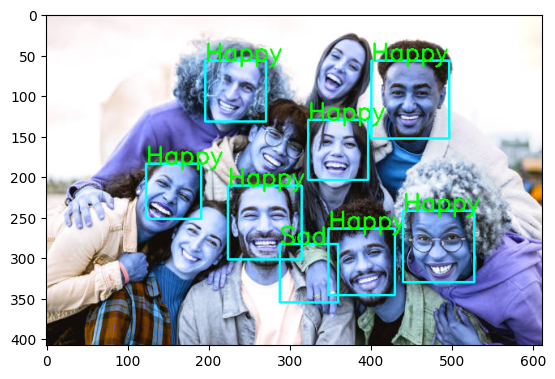

In [5]:
from  keras.models import load_model
from time import sleep
from tensorflow.keras.utils import load_img, img_to_array
import cv2 
import numpy as np
face_classifier=cv2.CascadeClassifier(r'K:\Python Project\Emotion Recognition\haarcascade_frontalface_default.xml')

classifier = load_model(r'K:\Python Project\Emotion Recognition\model_weights.h5', compile=False) 
emotion_labels = ['Angry','Disgust','Fear','Happy','Neutral', 'Sad', 'Surprise']
frame=cv2.imread("test.jpg")
labels = []
gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
faces = face_classifier.detectMultiScale(gray)

for (x,y,w,h) in faces:
    cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,255),2)
    roi_gray = gray[y:y+h,x:x+w]
    roi_gray = cv2.resize(roi_gray,(48,48),interpolation=cv2.INTER_AREA)



    if np.sum([roi_gray])!=0:
        roi = roi_gray.astype('float')/255.0
        roi = img_to_array(roi)
        roi = np.expand_dims(roi,axis=0)

        prediction = classifier.predict(roi)[0]
        label=emotion_labels[prediction.argmax()]
        label_position = (x,y)
        cv2.putText(frame,label,label_position,cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)
    else:
        cv2.putText(frame,'No Faces',(30,80),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)


imgplot = plt.imshow(frame)
plt.show()